In [ ]:
!git clone https://github.com/sehyungp92/mmdetection
!pip install mmcv==0.6.2 terminaltables
%cd mmdetection
!python setup.py develop
!pip install "git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools"

In [ ]:
import os
import sys
import random
import itertools
import colorsys
import glob

import numpy as np
import torch
from skimage.measure import find_contours
import skimage.color
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
from matplotlib import patches, lines
from matplotlib.patches import Polygon
import cv2
import IPython.display

In [ ]:
import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
from mmdet.models import build_detector
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import pycocotools.mask as mask_util
from pycocotools.coco import COCO
from torchvision.ops import nms
import json
import copy

In [ ]:
import matplotlib
from PIL import Image, ImagePalette

Visualisation

In [ ]:
def random_colors(N, bright=True):
    random.seed(216)
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(8, 8), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

def display_masks(image, masks, title="", figsize=(8, 8), ax=None, 
                  show_mask=True, colors=None):

    # Number of instances
    N = masks.shape[2]
    if not N:
        print("\n*** No instances to display *** \n")

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
        
def draw_results(model, filename, score_thr):

    img = filename
    image = skimage.io.imread(img)
    result = inference_detector(model, img)
    
    bbox_result, segm_result = result
    bboxes = np.vstack(bbox_result)
    inds = np.where(bboxes[:, -1]>score_thr)[0]
    i = [1,0,3,2,4]
    bboxes = bboxes[:,i][inds]
    if isinstance(segm_result, tuple):
        segm_result = segm_result[0]  # ms rcnn
    segs = np.array(segm_result[0])[inds].transpose(1,2,0)
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)[inds]
    scores = bboxes[:, -1]

    display_instances(image, bboxes[:,:-1], segs, labels, model.CLASSES, scores)

Ensemble

In [ ]:
def compute_iou_masks(masks1, masks2):
    
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

def compute_overlap_masks(masks1, masks2):
    
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    intersections = np.dot(masks1.T, masks2)
    overlaps = intersections / min(area1, area2)

    return overlaps

def compute_self_overlap_masks(masks1, masks2):
    
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    intersections = np.dot(masks1.T, masks2)
    overlaps = intersections / area1

    return overlaps

def hard_overlaps_suppression(binary_mask):
    
    not_overlap_mask = []
    for i in range(binary_mask.shape[0]):
        current_mask = binary_mask[i, ...].copy()
        for mask in not_overlap_mask:
            current_mask = np.bitwise_and(current_mask, np.invert(mask))
        not_overlap_mask.append(current_mask)
    
    return np.stack(not_overlap_mask)

def dense_crf(original_image, mask_img, epochs, gsxy, gcompat, bsxy, bsrgb, bcompat):
    
    if(len(mask_img.shape)<3):
        mask_img = skimage.color.gray2rgb(mask_img)
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    colors, labels = np.unique(annotated_label, return_inverse=True)
    n_labels = 2 
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=gsxy, compat=gcompat, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=bsxy, srgb=bsrgb, rgbim=original_image, compat=bcompat)
    Q = d.inference(epochs)
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
def ensemble_masks(res, iou_thresh, mask_thresh, use_nms, nms_thresh, beta, hard_overlap_sup, overlap_sup):
    
    nres = len(res)
    w = 1/float(nres)
    weights = [w]*nres    

    out = []
    out_scores = []
    out_bbox = []
    used = []
    for i in range(nres):
        bbox, seg = res[i]
        bboxes = bbox[:, :-1].tolist()
        scores = bbox[:, -1]

        unused = []
        unused_scores = []
        unused_bbox = []
        for idx in range(len(bboxes)):
            if bboxes[idx] not in used:
                unused.append(seg[idx])
                unused_scores.append(scores[idx])
                unused_bbox.append(bboxes[idx])

        for idx in range(len(unused_bbox)):
            used.append(unused_bbox[idx])

            found = []
            found_bbox = []
            found_score = []
            for j in range(nres):
                obbox, oseg = res[j]
                obboxes = obbox[:, :-1].tolist()
                oscores = obbox[:, -1]

                if bboxes == obboxes:
                    continue

                bestmask = None
                bestbbox = None
                bestscore = 0
                bestiou = iou_thresh

                for oidx in range(len(obboxes)):
                    if obboxes[oidx] not in used:
                        iou = compute_iou_masks(unused[idx][:,:,np.newaxis], oseg[oidx][:,:,np.newaxis])
                        if iou > bestiou:
                            bestiou = iou
                            bestmask = oseg[oidx]
                            bestbbox = obboxes[oidx]
                            bestscore = oscores[oidx]                            
                if not bestmask is None:
                    # found.append(bestmask*weights[j])
                    found.append(bestmask)
                    found_bbox.append(bestbbox)
                    found_score.append(bestscore)
                    used.append(bestbbox)                
            
            # found.append(seg[idx]*weights[i])
            found.append(unused[idx])
            found_bbox.append(unused_bbox[idx])
            found_score.append(unused_scores[idx])
            score_len = len(found_score)
            score_weight = 1/(beta**(score_len-2)) 

            # merged_masks = np.sum(np.array(found), axis=0)
            merged_masks = np.mean(np.array(found), axis=0)
            merged_masks = (merged_masks >= mask_thresh)
            merged_box = np.mean(np.vstack(found_bbox), axis=0)
            merged_score = np.mean(np.array(found_score)) ** score_weight
            # print(found_score, merged_score)

            if not np.all(merged_masks==0):
                out.append(merged_masks)
                out_bbox.append(merged_box)
                out_scores.append(merged_score)

    if use_nms:
        inds = nms(torch.Tensor(out_bbox), torch.Tensor(out_scores), nms_thresh)
        inds = inds.numpy()
    else:
        inds = np.argsort(out_scores)[::-1]

    # print(inds)
    out = np.array(out)[inds]
    out_bbox = np.array(out_bbox)[inds]
    out_scores = np.array(out_scores)[inds]
    if overlap_sup:
        ex_ind = []
        used_bbox = []
        out_bbox_lst = out_bbox.tolist()
        for i in range(len(out_bbox_lst)):
            used_bbox.append(out_bbox_lst[i])
            for j in range(len(out_bbox_lst)):
                if out_bbox_lst[j] not in used_bbox:
                    overlap = compute_overlap_masks(out[i][:,:,np.newaxis], out[j][:,:,np.newaxis])
                    if overlap > iou_thresh:
                        ex_ind.append(j)
                        # used_bbox.append(out_bbox_lst[j])
        in_ind = [i for i in range(len(out_bbox_lst)) if i not in ex_ind]
        in_ind = np.array(in_ind)
        out = out[in_ind]
        out_bbox = out_bbox[in_ind]
        out_scores = out_scores[in_ind]
    if hard_overlap_sup:
        out = hard_overlaps_suppression(out)
        in_ind = [i for i in range(out.shape[0]) if not np.all(out[i]==0)]
        out = out[in_ind]
        out_bbox = out_bbox[in_ind]
        out_scores = out_scores[in_ind]
        # print(in_ind)
    
    return out, out_scores

In [ ]:
def create_json(image_files, 
                models,
                file_name_len,
                score_thr=0.01,
                class_thr=0.8,
                iou_thresh=0.5, 
                mask_thresh=0.5,
                use_nms=True,
                nms_thresh=0.8, 
                beta=2,
                starting_image_id=1,
                overlap_sup=True,
                hard_overlap_sup=True,
                crf=False,
                epochs=10,
                gsxy=3, 
                gcompat=4, 
                bsxy=70, 
                bsrgb=25, 
                bcompat=2.75,
                visualise=False):

    image_info = []
    labels_info = []
    label_id = 1
    image_id = starting_image_id

    results = dict()
    avg_scores = dict()

    for instance in image_files:
        print(instance)
        image = skimage.io.imread(instance)
        res = []
        
        for mod in models:
            model = init_detector(mod[0], mod[1])
            result = inference_detector(model, instance)
            bbox_result, segm_result = result
            bboxes = np.vstack(bbox_result)
            inds = np.where(bboxes[:, -1]>score_thr)[0]
            bboxes = bboxes[inds]
            scores = bboxes[:, -1]

            if isinstance(segm_result, tuple):
                segm_result = segm_result[0]
            segm_result = np.array(segm_result[0])[inds]
            res.append((bboxes, segm_result))      

        segs, scores = ensemble_masks(res, iou_thresh, mask_thresh, use_nms=use_nms, nms_thresh=nms_thresh, beta=beta, 
                                      overlap_sup=overlap_sup, hard_overlap_sup=hard_overlap_sup)
        ind = np.argsort(scores)[::-1]
        scores = np.array(scores)[ind][:100]
        avg_score = np.mean(np.array(scores))
        # print(avg_score)
        avg_scores[instance] = avg_score, scores
        segs = segs[ind][:100]

        final_ind = np.where(scores>class_thr)[0]
        segs = segs[final_ind]
        results[instance] = segs.transpose(1,2,0)
        idx = 1

        image_info.append(
                {
                "id": image_id, 
                "file_name": instance[file_name_len:],
                "height": segs.shape[1],
                "width": segs.shape[2],
                "date_captured": "2020"             
                },
            )
        
        for seg in segs:
            if crf:
                crf_output = dense_crf(image, seg, epochs=epochs, 
                                       gsxy=gsxy, gcompat=gcompat, 
                                       bsxy=bsxy, bsrgb=bsrgb, bcompat=bcompat)
                crf_output = crf_output.astype('bool') 
            else:
                crf_output = seg

            if visualise:
                plt.figure(figsize=(25,25))
                plt.subplots_adjust(wspace=0.1,hspace=0.1)
                plt.subplot(len(segs),4,4*idx-3)
                plt.imshow(image)
                plt.title('Original image')
                plt.subplot(len(segs),4,4*idx-2)
                plt.imshow(seg)     
                plt.title('Original Mask')
                plt.subplot(len(segs),4,4*idx-1)
                plt.imshow(crf_output) 
                plt.title('Mask after CRF')
                idx += 1

            contours, hierarchy = cv2.findContours((crf_output).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:            
                contour = contour.flatten().tolist()            
                
                if len(contour) > 4:
                    segmentation.append(contour)
            if len(segmentation) == 0:
                continue
            
            rle = mask_util.encode(np.asfortranarray(crf_output))
            gt_area = mask_util.area(rle)
            gt_bbox = mask_util.toBbox(rle)

            labels_info.append(
                {
                "segmentation": segmentation,
                "area": int(gt_area),
                "iscrowd": 0,
                "image_id": image_id,
                "bbox": gt_bbox.tolist(),
                "category_id": 1,
                "id": label_id
                },
            )
            label_id += 1
        image_id += 1
    
    annotation = dict()
    annotation["images"] = image_info
    annotation["annotations"] = labels_info
    annotation["categories"] = [{"supercategory": "agnostic",
                                "id": 1,
                                "name": "object"}]

    return results, avg_scores, annotation

In [ ]:
def filter_images(image_files, res, res_a, res_b, avg_scores_b, score_thr, mode='both'):
    
    exclude = []
    for idx, instance in enumerate(image_files):
        # print(instance)
        results = res[instance] 
        results_a = res_a[instance]
        results_b = res_b[instance]
        scores_b = avg_scores_b[instance][1]
        ind = np.where(scores_b>score_thr)[0]
        results_b = results_b[:,:,ind]
        hc_overlap = []
        no_overlap = []
        used = []
        for i in range(results_a.shape[2]): 
            used.append(results_a[:,:,i])
            for j in range(results_a.shape[2]):
                if not any((results_a[:,:,j] == x).all() for x in used):
                    overlap = compute_overlap_masks(results_a[:,:,i][:,:,np.newaxis], results_a[:,:,j][:,:,np.newaxis])
                    if overlap>0.4:
                        hc_overlap.append(j)
        for i in range(results_b.shape[2]):
            overlap_vals = []
            for j in range(results.shape[2]):
                overlap = compute_self_overlap_masks(results_b[:,:,i][:,:,np.newaxis], results[:,:,j][:,:,np.newaxis])
                overlap_vals.append(overlap)
            # print(overlap_vals)
            if all(i<0.4 for i in overlap_vals):
                no_overlap.append(i)
        # print(hc_overlap, no_overlap)
        if mode=='both':
            if hc_overlap or no_overlap:
                exclude.append(idx)
        elif mode=='no_overlap':
            if no_overlap:
                exclude.append(idx)
        elif mode=='hc_overlap':
            if hc_overlap:
                exclude.append(idx)

    return exclude

In [ ]:
def compile_image_list(image_number, image_file, file_name_len):
    
    image_list = [image_file[i][file_name_len:] for i in image_number]
    return image_list

def exclude_images(annotations, image_list):

    # Filter images by file name
    ex_images = list()
    ex_images_id = list()
    in_images = list()
    for image in annotations["images"]:
        if image["file_name"] in image_list:
            ex_images.append(image)
            ex_images_id.append(image["id"])
        else:
            in_images.append(image)

    print(len(in_images), len(ex_images))

    # Filter annotations by image id
    ex_annotations = list()
    in_annotations = list()
    for annotation in annotations["annotations"]:
        if annotation["image_id"] in ex_images_id:
            ex_annotations.append(annotation)
        else:
            in_annotations.append(annotation)

    print(len(in_annotations), len(ex_annotations))

    ex_instances = copy.deepcopy(annotations)
    ex_instances.update({"images": ex_images, "annotations": ex_annotations})

    in_instances = copy.deepcopy(annotations)
    in_instances.update({"images": in_images, "annotations": in_annotations})

    return in_instances, ex_instances

def include_images(annotations, image_list):

    # Filter images by file name
    in_images = list()
    in_images_id = list()
    ex_images = list()
    for image in annotations["images"]:
        if image["file_name"] in image_list:
            in_images.append(image)
            in_images_id.append(image["id"])
        else:
            ex_images.append(image)

    print(len(in_images), len(ex_images))

    # Filter annotations by image id
    in_annotations = list()
    ex_annotations = list()
    for annotation in annotations["annotations"]:
        if annotation["image_id"] in in_images_id:
            in_annotations.append(annotation)
        else:
            ex_annotations.append(annotation)

    print(len(in_annotations), len(ex_annotations))

    in_instances = copy.deepcopy(annotations)
    in_instances.update({"images": in_images, "annotations": in_annotations})

    ex_instances = copy.deepcopy(annotations)
    ex_instances.update({"images": ex_images, "annotations": ex_annotations})

    return in_instances, ex_instances

Define Location of Images

In [ ]:
file_loc_3_a = "/content/manually_labelled/sparse_obscure_a/"
image_files_3_a = glob.glob(file_loc_3_a + "*.jpg")
image_files_3_a = sorted(image_files_3_a)
print(len(image_files_3_a))

Define Models To Use

In [ ]:
models = [
          ("/content/mmdetection/configs/project/htc_resnet101_mstest_softnms.py", "/content/PATH_TO_MODEL/MODEL.pth"),
          ("/content/mmdetection/configs/project/htc_resnext_mstest_softnms.py", "/content/model_output/PATH_TO_MODEL/MODEL.pth"),
          ("/content/mmdetection/configs/project/htc_dcn_resnext_mstest_softnms.py", "/content/model_output/PATH_TO_MODEL/MODEL.pth")
          ]

checkpoint_file_1 = os.path.join("/content/PATH_TO_MODEL/", "MODEL.pth")
model_1 = init_detector("/content/mmdetection/configs/project/htc_resnet101_mstest_softnms.py", checkpoint_file_1)

checkpoint_file_2 = os.path.join("/content/PATH_TO_MODEL/", "MODEL.pth")
model_2 = init_detector("/content/mmdetection/configs/project/htc_resnext_mstest_softnms.py", checkpoint_file_2)

checkpoint_file_3 = os.path.join("/content/PATH_TO_MODEL/", "MODEL.pth")
model_3 = init_detector("/content/mmdetection/configs/project/htc_dcn_resnext_mstest_softnms.py", checkpoint_file_3)

In [ ]:
exclude_test = filter_images(image_files_test, results_test, results_test_a, results_test_a, avg_scores_test_a, score_thr=0.3)
print(exclude_test)

Generate Pseudo Labels

In [ ]:
results_3_a, avg_scores_3_a, annotation_3_a = create_json(image_files_3_a,
                                                          models,
                                                          file_name_len=len(file_loc_3_a),
                                                          score_thr=0.9,
                                                          class_thr=0.9, 
                                                          iou_thresh=0.5, 
                                                          mask_thresh=0.5,
                                                          nms_thresh=0.8, 
                                                          beta=1,
                                                          starting_image_id=300, 
                                                          overlap_sup=True,
                                                          hard_overlap_sup=True,
                                                          crf=True, 
                                                          epochs=10,
                                                          gsxy=3, gcompat=3, 
                                                          bsxy=70, bsrgb=25, bcompat=3,
                                                          visualise=False)

0


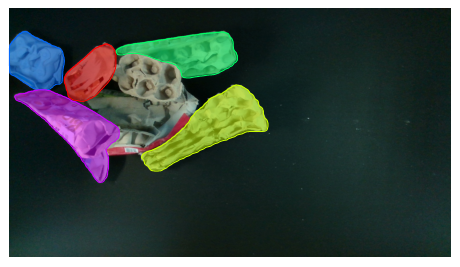

1


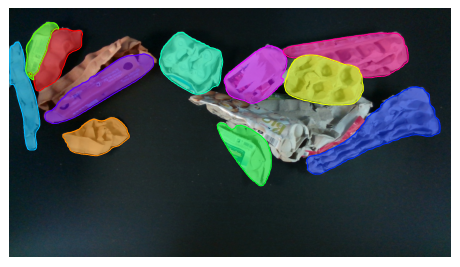

2


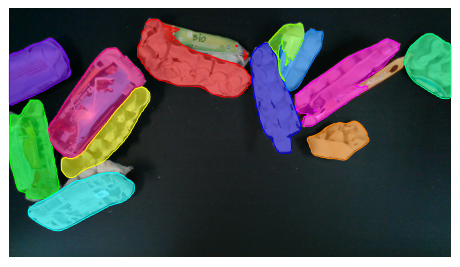

3


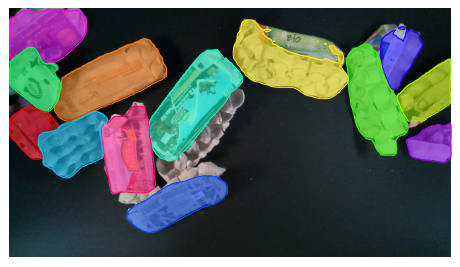

4


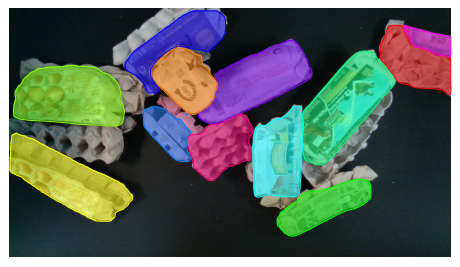

5


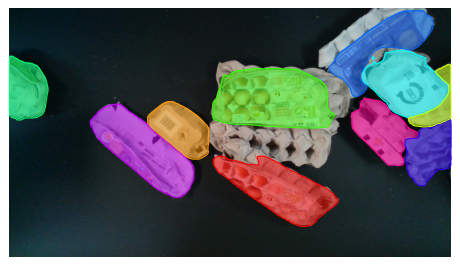

6


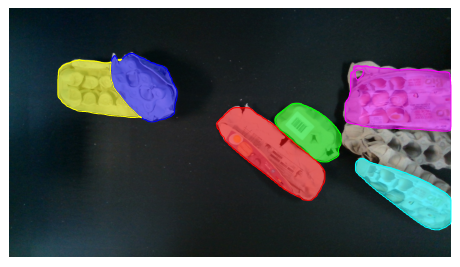

7


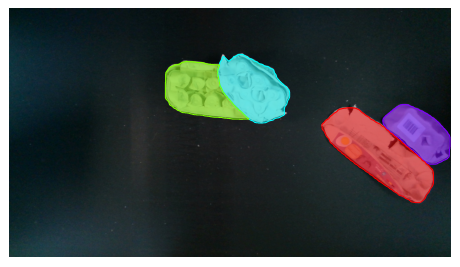

8


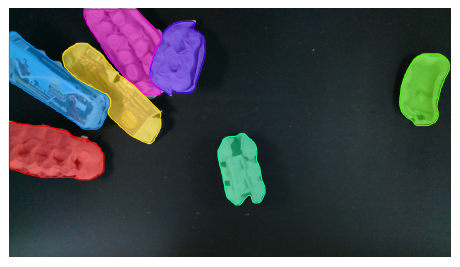

9


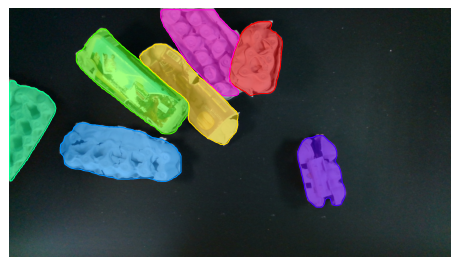

10


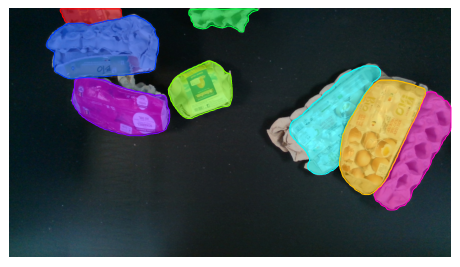

11


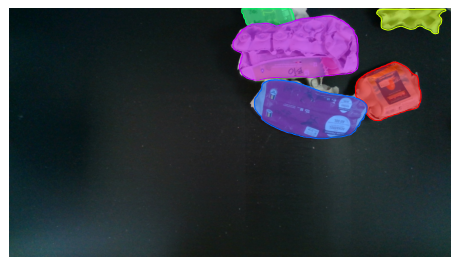

12


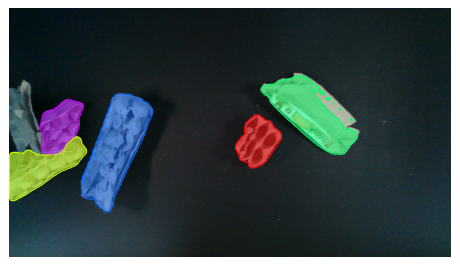

13


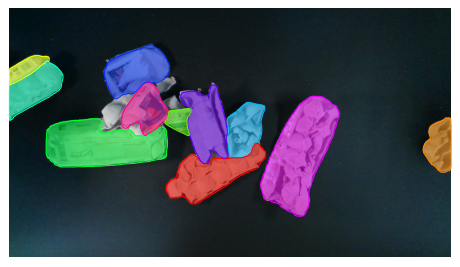

14


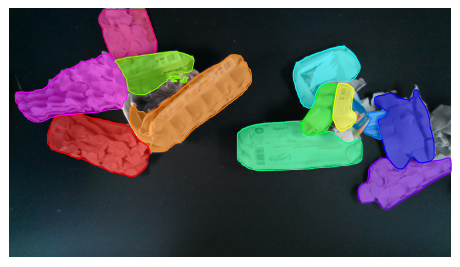

15


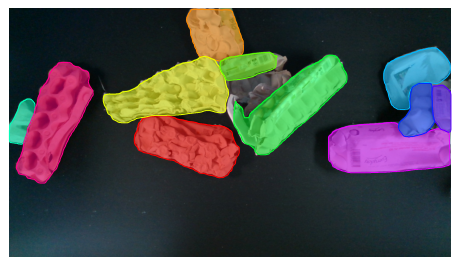

16


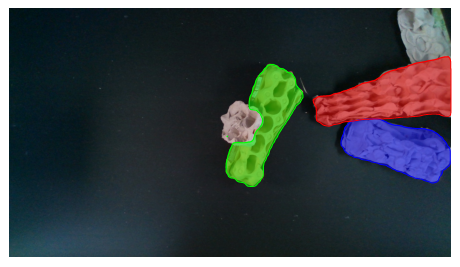

17


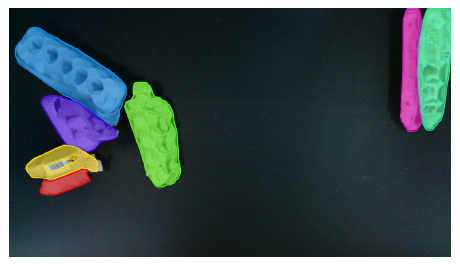

18


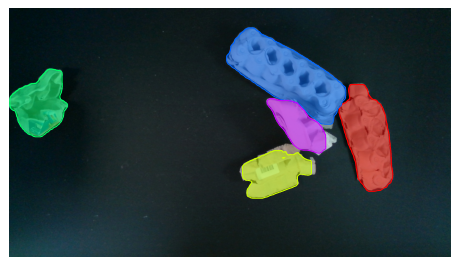

19


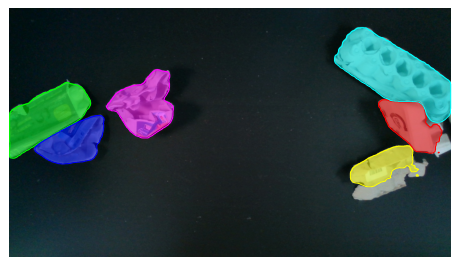

20


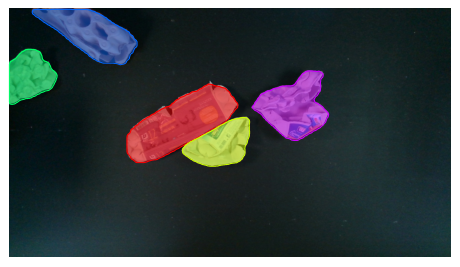

21


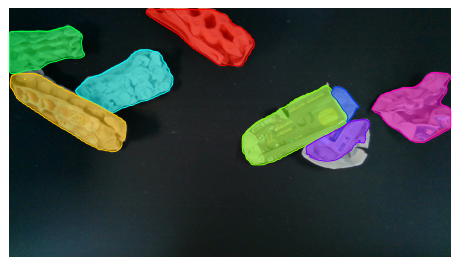

22


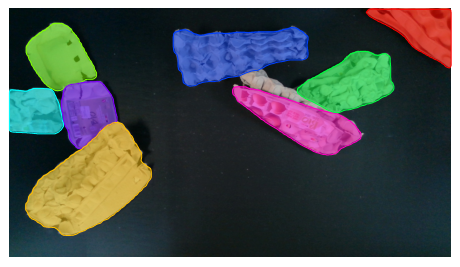

23


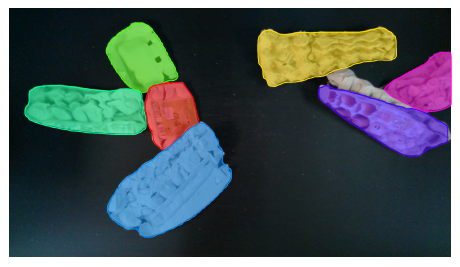

24


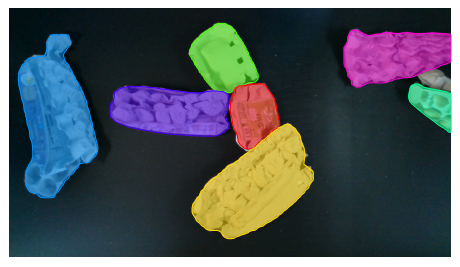

25


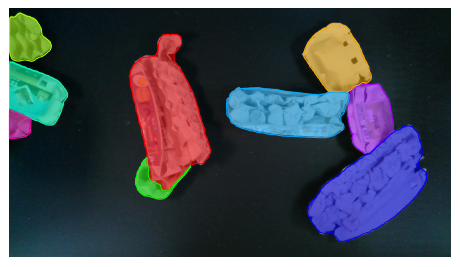

26


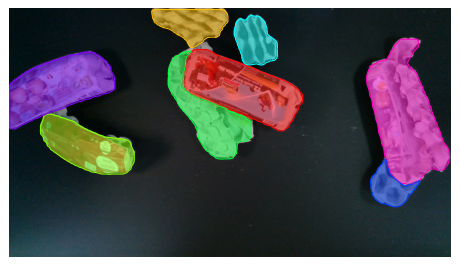

27


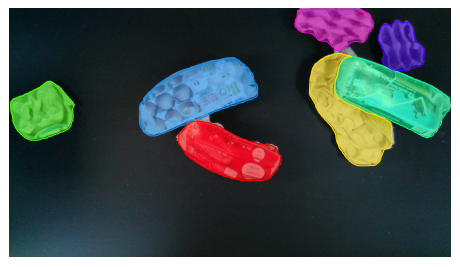

28


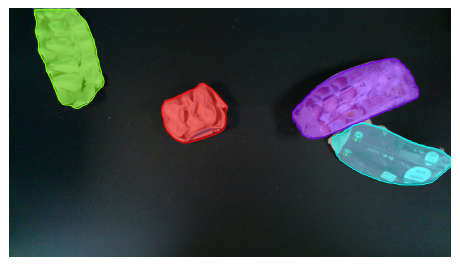

29


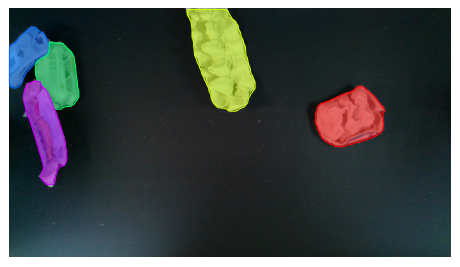

30


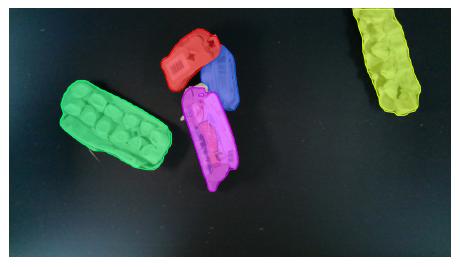

31


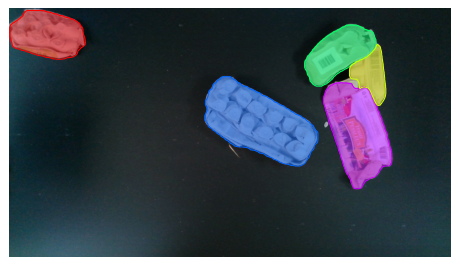

32


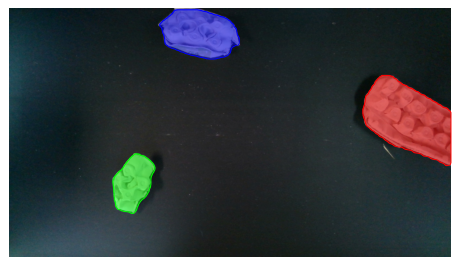

33


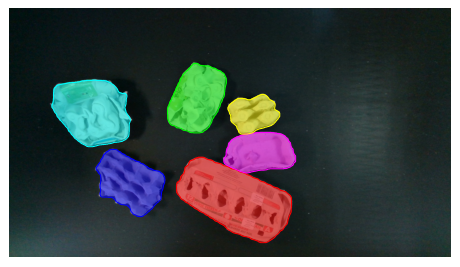

34


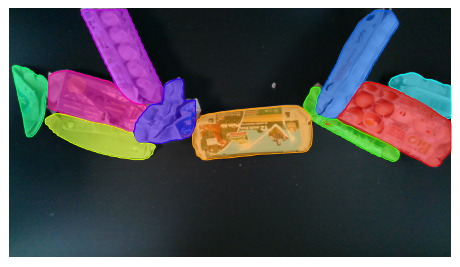

35


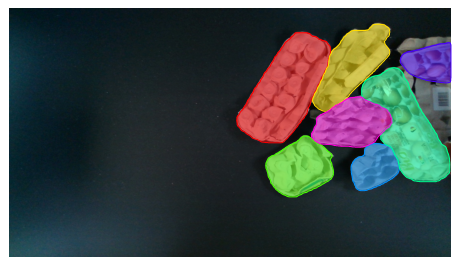

In [ ]:
for idx, instance in enumerate(image_files_3_a):
    image = skimage.io.imread(instance)
    result = results_3_a[instance]
    print(idx)
    display_masks(image, result)

In [ ]:
results_3a_a, avg_scores_3a_a, annotation_3a_a = create_json(image_files_3_a,
                                                             models,
                                                             file_name_len=len(file_loc_3_a),
                                                             score_thr=0.9,
                                                             class_thr=0.9, 
                                                             iou_thresh=0.5, 
                                                             mask_thresh=0.5,
                                                             nms_thresh=0.8, 
                                                             beta=1,
                                                             starting_image_id=300, 
                                                             overlap_sup=False,
                                                             hard_overlap_sup=False,
                                                             crf=False, 
                                                             epochs=10,
                                                             gsxy=3, gcompat=4, 
                                                             bsxy=70, bsrgb=25, bcompat=2.5,
                                                             visualise=False)

In [ ]:
results_3b_a, avg_scores_3b_a, annotation_3b_a = create_json(image_files_3_a,
                                                             models,
                                                             file_name_len=len(file_loc_3_a),
                                                             score_thr=0.3,
                                                             class_thr=0.3, 
                                                             iou_thresh=0.5, 
                                                             mask_thresh=0.5,
                                                             nms_thresh=0.8, 
                                                             beta=1,
                                                             starting_image_id=300, 
                                                             overlap_sup=False,
                                                             hard_overlap_sup=False,
                                                             crf=False, 
                                                             epochs=10,
                                                             gsxy=3, gcompat=4, 
                                                             bsxy=70, bsrgb=25, bcompat=2.5,
                                                             visualise=False)

Apply Filter to Remove False Positive and Negatives

In [ ]:
exclude_3_a = filter_images(image_files_3_a, results_3_a, results_3a_a, results_3b_a, avg_scores_3b_a, score_thr=0.3)
print(exclude_3_a)

[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 35]


In [ ]:
exclude_3_a = filter_images(image_files_3_a, results_3_a, results_3a_a, results_3b_a, avg_scores_3b_a, score_thr=0.3, mode='hc_overlap')
print(exclude_3_a)

[5, 18, 20]


In [ ]:
exclude_3_a = filter_images(image_files_3_a, results_3_a, results_3a_a, results_3b_a, avg_scores_3b_a, score_thr=0.3, mode='no_overlap')
print(exclude_3_a)

[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 19, 21, 23, 24, 35]


Create Annotations

In [ ]:
with open("/content/manually_labelled/annotations/annotation_3_a" + '.json', 'w', encoding='utf8') as json_file:
    json.dump(annotation_3_a, json_file)